# `CLOUD.jl` - 2D linear advection

In [25]:
using CLOUD
using Plots
using LinearAlgebra
using OrdinaryDiffEq
plots_path = "../plots/advection2d_demo/"
results_path = "../results/advection2d_demo/";

Define the physical problem

In [26]:
a = (1.0,0.0)  # advection velocity
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = L  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation(a,λ=1.0);

Set up a quadrature-based DG scheme of degree `p` with `M` elements

In [27]:
M = 5  # number of elements
p = 3  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGMulti(p), Tri(), N_plot=ceil(Int,50/M));
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation);
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, StrongConservationForm(), 
     (0.0, T), Eager(), results_path, overwrite=true, clear=true);

Run the `OrdinaryDiffEq` solver with RK4, taking `n_s` snapshots

In [28]:
n_s = 10
dt_scale=0.01
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false,
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final");

Visualize the solution and calculate the integral L<sup>2</sup> error norm

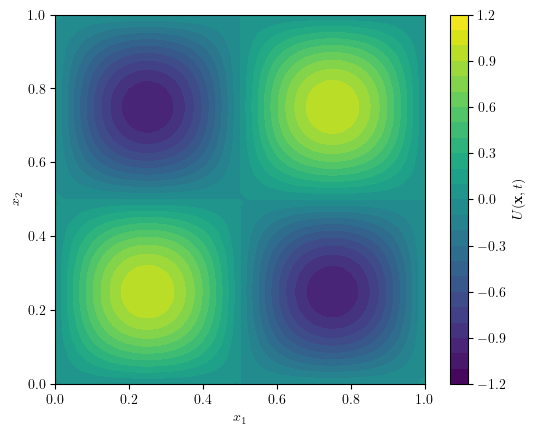

In [34]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25)

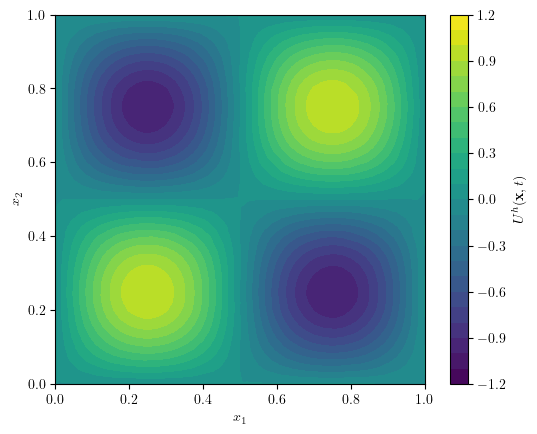

In [35]:
visualize(last(sol.u),plotter, "approx.pdf", 
    u_range=[-1.0,1.0], contours=25, label="U^h(\\mathbf{x},t)")

In [31]:
error_analysis = ErrorAnalysis(conservation_law, spatial_discretization, results_path)
print("L2 error: ", analyze(error_analysis, last(sol.u), initial_data)[1])
#unew = copy(ode_problem.u0)
#rhs!(unew,ode_problem.u0, ode_problem.p, 0.0, print=true);

L2 error: 0.0021891045419827485